In [2]:
import matplotlib.pyplot as plt
import numpy as np
from findiff import FinDiff
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import axes3d
import scipy
import time
import numpy as np
import pandas as pd
import random
import torch
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from IPython.display import clear_output
plt.rcParams["font.family"] = "serif"

In [18]:
#read csv
df = pd.read_csv(r'DATA/Temperatures.csv')
t = pd.read_csv(r'DATA/Times.csv')
t = t-820469098 #correct times :)

## Red

Quiero ir modificando un par de cosas:

- Adimensionalizar en el tiempo: $8324s$ es el máximo
- No olvidarme de admiensionalizar al constante $\kappa$. Como vá como $\sim \frac{cm^{2}}{s} \rightarrow \kappa' \sim (8324)cm^{2}$
- Dejar fijo el parámetro de capa en pincipio
- Modificar para mandarle a la red no puntos en un linspace de $x$ y de $t$
- Mandar menos puntos, y entrenar con menos puntos también
- Agregar las condiciones de contorno como parte del error físico. Estas van a venir dadas por las condiciones de contorno de la ecuacion del calor, que para el caso tipo Neumann:
$$ -\frac{\partial U (x=0 , t)}{\partial x} = P = \frac{V^{2}}{R} = \frac{(23.8 V)^{2}}{(11.1 \Omega)},$$
$$\frac{\partial U(x=50cm, t)}{\partial x} = 0.$$
- Necesito entender como evaluar la condicion de contorno, osea generarme un error por la física pero que sea solo en 2 puntos.

  

In [29]:
V = 23.8  # Voltage in volts
R = 11.1  # Resistance in ohms
dT_dx = 2.93  # Temperature gradient in °C/cm
L = 50  # Length of the rod in cm

#Calculate power
P = (V ** 2) / R

#Calculate ΔT
delta_T = dT_dx * L  # °C

#Calculate alpha (thermal diffusivity)
alpha = P / (R * delta_T)  # in cm²/s

# Results
P, delta_T, alpha

(51.03063063063064, 146.5, 0.03138125672947185)

In [5]:
#Positions where the thermocouples measurements are taken.
x0 = np.array([8.14, 12.31, 16.41, 21.13, 24.96, 41.05])

In [7]:
k = 1.6      #Estimated value of \kappa to start training.
class MLP2(torch.nn.Module):

    def __init__(self,sizes):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.ka = torch.nn.Parameter(data=torch.Tensor([k]), requires_grad=True)
        for i in range(len(sizes)-1):
            self.layers.append(torch.nn.Linear(sizes[i],sizes[i+1]))
    def forward(self,x):
        h = x
        for hidden in self.layers[:-1]:
            h = torch.tanh(hidden(h))
        output = self.layers[-1]
        y = output(h)
        return y

In [8]:
#Boundary conditions

x_data_cc50 = (50* torch.tensor( torch.ones(100))).view(-1,1) .requires_grad_(True)#100 posiciones para x = 0, 100 para x = 2pi
x_data_cc0 = (50* torch.tensor(torch.zeros(100))).view(-1,1) .requires_grad_(True)
t_data_cc0   = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)
t_data_cc50    = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)

input_cc0 = torch.cat((x_data_cc0.flatten().view(-1,1), t_data_cc0.flatten().view(-1,1)), dim=1)
input_cc50 = torch.cat((x_data_cc50.flatten().view(-1,1), t_data_cc50.flatten().view(-1,1)), dim=1)

#x_data_cc    = 50* torch.cat((torch.zeros(100), torch.ones(100)), dim = 0).view(-1,1) .requires_grad_(True)#100 posiciones para x = 0, 100 para x = 2pi
#t_data_cc    = torch.cat((torch.linspace(0,1,100), torch.linspace(0,1,100)), dim = 0).view(-1,1).requires_grad_(True) #100 valores del tiempo entre 0 y 1 (normalizado) para cada contorno
#input_cc = torch.cat((x_data_cc.flatten().view(-1,1), t_data_cc.flatten().view(-1,1)), dim=1) #junto x y t

/tmp/ipykernel_6267/2721613964.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data_cc50 = (50* torch.tensor( torch.ones(100))).view(-1,1) .requires_grad_(True)#100 posiciones para x = 0, 100 para x = 2pi
/tmp/ipykernel_6267/2721613964.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data_cc0 = (50* torch.tensor(torch.zeros(100))).view(-1,1) .requires_grad_(True)


In [9]:
#Physics to train

t_physics = torch.linspace(0,1,200).requires_grad_(True)
x_physics = torch.linspace(0,50, 50).requires_grad_(True)
x_grid, t_grid = torch.meshgrid(x_physics, t_physics, indexing='ij')
x_grid = x_grid[:,:,None].requires_grad_(True) # add a dimension at the end so it can be used as input for the network
t_grid = t_grid[:,:,None].requires_grad_(True) 
input_physics = torch.cat((x_grid, t_grid), dim=-1)

In [10]:
#Select a subset of elements to train the network (it can be done with all of them)

x1, t1 = df.iloc[0, 2:1721][::30], t.iloc[0, 2:1721][::30]
x2, t2 = df.iloc[1, 2:1721][::30], t.iloc[1, 2:1721][::30]
x3, t3 = df.iloc[2, 2:1721][::30], t.iloc[2, 2:1721][::30]
x4, t4 = df.iloc[3, 2:1721][::30], t.iloc[3, 2:1721][::30]
x5, t5 = df.iloc[4, 2:1721][::30], t.iloc[4, 2:1721][::30]
x6, t6 = df.iloc[5, 2:1721][::30], t.iloc[5, 2:1721][::30]

In [11]:
u_data = []
for x in [x1, x2, x3, x4, x5]:
    u_data.append(x.tolist())
u_data = torch.tensor(u_data).requires_grad_(True).view(-1,1)
t_data = [torch.from_numpy(t.to_numpy()).view(-1, 1).float() for t in [t1, t2, t3, t4, t5]]
t_data_nor = [t / 8253 for t in t_data]
x0 = torch.tensor([8.14, 12.31, 16.41, 21.13, 24.96])
#x0_exp = [x0_data[i].expand(t.shape) for i, t in enumerate(t_data_nor)]

In [12]:
#Since the times of the thermocouples are the same, I take just one (t4), normalize it, and create a meshgrid.

t = torch.from_numpy((t4/ 8253).to_numpy()).float()
x_data_grid, t_data_grid = torch.meshgrid(x0,t,indexing= 'ij')
x_data_grid = x_data_grid[:,:,None]
t_data_grid = t_data_grid[:,:,None]
input_data = torch.cat((x_data_grid, t_data_grid), dim=-1)

In [13]:
#generate the PINN
pinn2 = MLP2([2,64,64,64, 64,1])

In [14]:
#I import the PINN if it is saved; otherwise, it starts running from scratch.
pinn2.load_state_dict(torch.load('pinn2_loss_perf_1e-5.pth'))
pinn2.eval()

/tmp/ipykernel_6267/2922430348.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn2.load_state_dict(torch.load('pinn2_loss_perf_1e-5.pth'))


MLP2(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [22]:
#Import loss if it is saved
loss_plt = np.loadtxt('loss_perf_1e-5.txt')
loss_plt.tolist()

[[54.24361801147461,
  1644484.125,
  0.004689030349254608,
  5.9206995501881465e-06],
 [54.43630599975586, 1640563.25, 0.004689121153205633, 5.917001089983387e-06],
 [54.62919235229492, 1636653.125, 0.004689210094511509, 5.913312179472996e-06],
 [54.82218933105469, 1632753.25, 0.004689299035817385, 5.9096287259308156e-06],
 [55.0156364440918, 1628866.75, 0.004689387511461973, 5.905950729356846e-06],
 [55.209205627441406, 1624990.75, 0.004689475521445274, 5.902284101466648e-06],
 [55.402896881103516, 1621125.5, 0.0046895635314285755, 5.898625659028767e-06],
 [55.596900939941406,
  1617272.125,
  0.0046896496787667274,
  5.894973128306447e-06],
 [55.791053771972656, 1613429.75, 0.004689737223088741, 5.891326509299688e-06],
 [55.985435485839844,
  1609598.375,
  0.004689822439104319,
  5.887689894734649e-06],
 [56.179962158203125, 1605777.75, 0.004689908120781183, 5.884059646632522e-06],
 [56.37469482421875, 1601968.0, 0.004689992871135473, 5.88043667448801e-06],
 [56.56974792480469, 159

In [25]:
with open('loss_perf_1e-5.txt', 'r') as file:
    list_ = file.readlines()

loss_plt = [line.strip() for line in list_]

In [17]:
#define a list to store the errors and then plot them.
loss_plt = []

In [26]:
#separate the optimizer to modify the learning rate
optimizer = torch.optim.Adam(pinn2.parameters(),lr=1e-5)

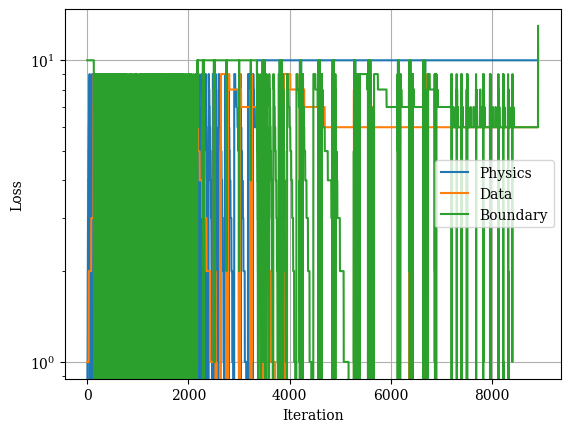

KeyboardInterrupt: 

In [27]:
#Training + plotting of the error on a logarithmic scale every 100 iterations.
plt.ion()  

iterations =  10000
l =    1e-5
lc = 1e-4
p = (23-8)**2/(11.1*1.6*8634)
for epoch in range(iterations):
    optimizer.zero_grad()
    u_pred = pinn2(input_data).view(-1,1)
    loss1 = torch.mean((u_pred - u_data)**2)

    
    u_cc50 = pinn2(input_cc50)
    u_cc0 = pinn2(input_cc0)
    loss3 = lc * torch.mean(torch.autograd.grad(u_cc50, x_data_cc50, torch.ones_like(u_cc50), create_graph=True)[0] ** 2)
    loss4 = lc * torch.mean(( torch.autograd.grad(u_cc0, x_data_cc0, torch.ones_like(u_cc0), create_graph=True)[0]+ p )**2)

    
    yhp = pinn2(input_physics)
    dx  = torch.autograd.grad(yhp, x_grid, torch.ones_like(yhp), create_graph=True)[0]# compute u_x
    dx2  = torch.autograd.grad(dx, x_grid, torch.ones_like(yhp), create_graph=True)[0]# compute u_xx
    dt  = torch.autograd.grad(yhp, t_grid, torch.ones_like(yhp), create_graph=True)[0]# compute u_t
    physics = pinn2.ka*8324*dx2-dt
    
    loss2 =  l * torch.mean(physics**2)  #Weighted MSE error by l
    #loss = loss1 + loss2 + loss3  #sum all the errors
    loss =  loss2 + loss1 + loss4 + loss3
    #loss_list = [loss1,loss2,loss4,loss3]
    #loss_plt.append(loss_list)
    
    loss.backward()
    
    optimizer.step()
    
    with torch.autograd.no_grad():
        
        loss_plt.append([float(loss1), float(loss2), float(loss3+loss4)])
        #print(epoch,'Data',float(loss1),  'Física:',float(loss2),'CC (0):',float(loss4),'CC (50):', float(loss3), "Traning Loss:",float(loss.data))
        if epoch % 100 == 0:
            
            clear_output(wait=True)  # Clear the current output to avoid stacking plots

            fig, ax = plt.subplots() 
            x_values = [sublist[0] for sublist in loss_plt]  # "Data"
            y_values = [sublist[1] for sublist in loss_plt]  # "Physics"
            z_values = [sublist[2] for sublist in loss_plt]  # "Boundary"

            # Plot the data
            ax.plot(range(len(loss_plt)), y_values,  label="Physics")
            ax.plot(range(len(loss_plt)), x_values,  label="Data")
            ax.plot(range(len(loss_plt)), z_values,  label="Boundary")
            ax.set_ylabel('Loss')
            ax.set_xlabel('Iteration')
            ax.set_yscale('log')
            #ax.set_xlim(5800)
            ax.grid(True)
            ax.legend()
            plt.show()
        

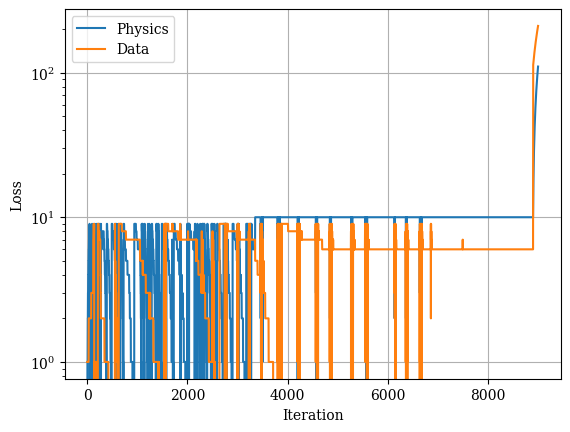

In [28]:
#Error as a function of the iteration
x_values = [sublist[0] for sublist in loss_plt]
y_values = [sublist[1] for sublist in loss_plt]

# Plotting
plt.plot(range(len(loss_plt)), y_values, label="Physics")  # Plot index vs second element
plt.plot(range(len(loss_plt)), x_values, label="Data")  # Plot index vs second element
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [172]:
# save the loss in a .txt file

with open('loss_sad_1e-1.txt', 'w') as file:
    for sublist in loss_plt:
        file.write(' '.join(map(str, sublist)) + '\n')

Text(0.5, 0, 'Tiempo (t_net)')

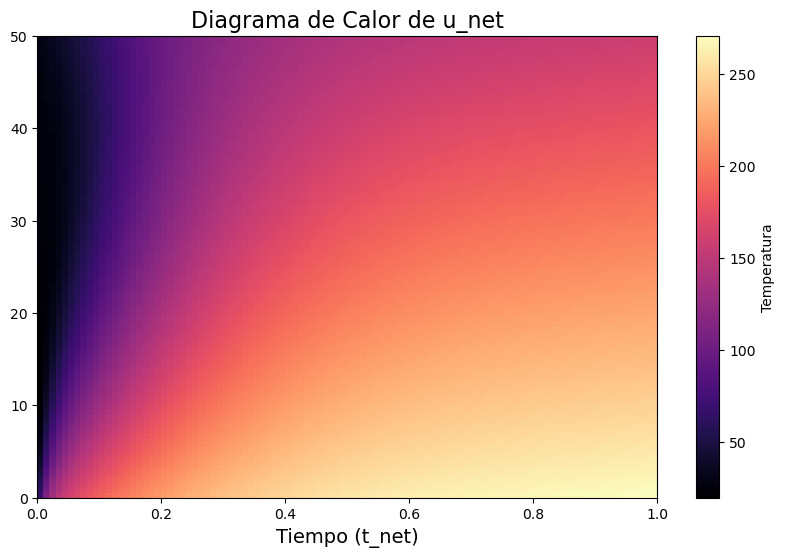

In [171]:
#heat map
u_net = pinn2(input_physics).detach().numpy().flatten()
u_net = u_net.reshape(len(t_grid), len(x_grid))
plt.figure(figsize=(10, 6))
plt.imshow(u_net, aspect='auto', cmap='magma', extent=[t_grid.detach().numpy().min(), t_grid.detach().numpy().max(), x_grid.detach().numpy().min(), x_grid.detach().numpy().max()], origin='lower')
plt.colorbar(label='Temperatures')
plt.xlabel('Times (t_net)', fontsize=14)
#plt.savefig('-.png', bbox_inches='tight')


In [173]:
#SAVE PINN
torch.save(pinn2.state_dict(), 'pinn2_loss_bad_1e-2.pth')